Will you be accepted?
====================

We are a Graduate Adminssions Consulting Firm and we want to add a policy that says "You get in or you get your money back."* Before we do that we want to be able to predict with high accuracy what schools a student may or may not be able to get into with a high probability so that we can steer them away from situations that would cost us money (or out right not sell them our services).

You are intentially given very little information thus far. You must communicate with your client (me) for additional information as you see fit. But also make sure that your communications are efficient, thought out, and not redundant as your client might get frustrated and "fire" you (this only applies to getting information from your client, this does not necessary apply to asking for help with the actual project itself).

For this project you must go through most steps in the checklist. You must write responses for all items however sometimes the item will simply be "does not apply". Some of the parts are a bit more nebulous and you simply show that you have done things in general. Keep your progress and thoughts organized in this document and use formatting as appropriate (using markdown to add headers and sub-headers for each major part). Do not do the final part (launching the product) and your presentation will be done as information written in this document in a dedicated section, no slides or anything like that. It should however include the best summary plots/graphics/data points.

\* Note that unlike some services, we don't cheat the system, we just make sure the applicant is shown in the best light and made to stand out.

Frame the Problem and Look at the Big Picture
======

1 Define the objective in business terms.

**This Graduate Admissions consulting firm has a policy where if you do not get into a school you apply to, you get your money back. To ensure they do not lose too much money, and their predicitons are more accurate, the company wants us to help them predict where students will get into and not get into schools by using data collected through the years prior.**

2 How will your solution be used?

**Our solution will be used to steer applicants away from graduate schools if they would not be accepted  and towards other options, so the company can continue to use this policy without losing too much money.**

3.What are the current solutions/workarounds (if any)?

**What the company currently does is each graduate applicant is matched someone on staff and they look over their profile and guess what level they are suited to or if they should be redirected to some other opportunity that isn't graduate school. So whoever the student is matched with gets to determine where they apply. They would solve this problem manually just by looking over the student's information and having someone predict. Not very reliable/reproducable.**

4 How should you frame this problem (supervised/unsupervised, online/offline, ...)?

**This is a supervised problem and online/offline does not matter. The dataset is not large enough to make a mini-batch online system necessary.**

5.How should performance be measured? Is the performance measure aligned with the business objective?

**The performance should be measured by calculating the Root Mean Squared Error because the function works with the Regressor models we intend to use. Root Mean Squared Error is also useful because each attribute has the same number of datapoints.**

6.What would be the minimum performance needed to reach the business objective?

**The minimum performance need to reach the business objective would be about 90% accuracy according to the client, and should not "round up" when determining the level of education they could be admitted into.**

7.What are comparable problems? Can you reuse experience or tools?

**California Housing Income would be comparable in terms of finding a solution. Other problems could also be useful such as MNIST, Early Spring, or Irises in terms of data exploration. There are other pieces of in class notebooks and examples that could be useful as well.**

8.Is human expertise available?

**The data was generated from this admissions consulting company and they are experts and often agree on the answer if which level of schooling the candidates could get into.**


9.How would you solve the problem manually?

**We would look over their profile to determine what level they are suited for or if they should be redirected to some other opportunity that isn't graduate school. Our staff would be the ones determining where they should apply using some sort of prediction. Not reliable/reproducable.**

10.List the assumptions you (or others) have made so far.

**None.**

Verify assumptions if possible.

**N/A**

# Imports

In [ ]:
import numpy as np
import pandas as pd
from mpl_toolkits import mplot3d
import matplotlib.pylab as plt

from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.linear_model import ElasticNet, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics import mean_squared_error

# Functions

In [ ]:
def read_data():
  """
  This function loads the data subset using for this assignment. This takes
  30-45 seconds to run.
  """
  return pd.read_csv('https://drive.google.com/uc?export=download&id=12UHYxG0qkqphzr81-xvkJ4Brf_bPTP0a', compression='xz')

In [ ]:
from sklearn.utils.metaestimators import if_delegate_has_method
class SupervisedPipeline(BaseEstimator):
  """
  This meta estimator wraps the entire process of preprocessing the data
  including allowing removal of rows containing bad data across the data and
  target for a supervised system and then splitting the target value from the
  data and finally training the model.
  """
  def __init__(self, train_preprocessor, label_column, preprocessor, estimator=None):
    """
    train_preprocessor - transformer, this preprocessor is only run on the full
                    dataset (i.e. X and y combined) and only during training.
                    The goal of this preprocessor should be to only remove rows
                    of data across both the data and labels. The result after
                    this transform should be data that is compatible with the
                    regular preprocessor that the testing data goes through
                    except that it also includes the label_column which will be
                    removed next.
    label_column  - the string name or the integer index of the column that
                    contains the label information (y).
    preprocessor  - transformer, likely a Pipeline or ColumnTransformer, that
                    performs all preprocessing on the data without the labels. 
                    It is used for both training and testing.
    estimator     - classifier or regressor that makes predictions. Can be None
                    in which case this class acts as a transformer.
    
    Overall training process (i.e. fit):
      Xt = train_preprocessor.fit_transform(X)
      y  = split off label_column from Xt
      Xt = preprocessor.fit_transform(Xt, y)
      estimator.fit(Xt, y)
      
    Overall testing process (i.e. predict and similar):
      Xt = preprocessor.transform(X)
      return estimator.predict(Xt)
      
      
    All of the standard Sklearn estimator methods are supported as long as they
    are supported by the given estimator. They can all take Xy datasets.
    The fit and score methods can take X and y separately and the prediction
    methods can take just X datasets.
    """
    super().__init__()
    self.train_preprocessor = train_preprocessor
    self.label_column = label_column
    self.preprocessor = preprocessor
    self.estimator = estimator
    
  @staticmethod
  def __fit_transform(trans, X, **fit_params):
    return trans.fit_transform(X, **fit_params) if hasattr(trans, 'fit_transform') else trans.fit(X).transform(X, **fit_params)

  def __split(self, X):
    """Splits the label column from the data"""
    if isinstance(X, pd.DataFrame):
      col = X.columns[self.label_column] if isinstance(self.label_column, int) else self.label_column
      y = X.loc[:,col]
      X = X.drop(columns=col)
    else:
      y = X[:,self.label_column]
      X = np.delete(X, self.label_column, 1)
    return X, y
  
  def __join(self, X, y):
    """Joins the label column into the data"""
    if isinstance(X, pd.DataFrame):
      X.insert(self.label_column if isinstance(self.label_column, int) else len(X.columns), self.label_column, y)
      Xy = X
    else:
      Xy = np.insert(X, self.label_column, y, axis=1)
    return Xy

  def __fit(self, X, y=None, **fit_params): # TODO: deal with fit_params like in Pipeline
    Xy = self.__join(X, y) if y is not None else X
    Xt = SupervisedPipeline.__fit_transform(self.train_preprocessor, Xy)
    Xt, y = self.__split(Xt)
    self.final_X_cols_ = Xt.shape[1]
    Xt = SupervisedPipeline.__fit_transform(self.preprocessor, Xt)
    return Xt, y, {}

  def fit(self, X, y=None, **fit_params):
    Xt, y, fit_params = self.__fit(X, y, **fit_params)
    if self.estimator is not None:
      if isinstance(Xt, pd.DataFrame): Xt = Xt.reset_index(drop=True)
      self.estimator.fit(Xt, y, **fit_params)
    return self
  
  @if_delegate_has_method(delegate='estimator')
  def fit_predict(self, X, y=None, **fit_params):
    Xt, y, fit_params = self.__fit(X, y, **fit_params)
    return self.estimator.fit_predict(Xt, y, **fit_params)
    
  @if_delegate_has_method(delegate='estimator')
  def predict(self, X, **predict_params):
    if X.shape[1] != self.final_X_cols_: X, _ = self.__split(X)
    if isinstance(X, pd.DataFrame): X = X.reset_index(drop=True)
    Xt = self.preprocessor.transform(X)
    return self.estimator.predict(Xt, **predict_params)

  @if_delegate_has_method(delegate='estimator')
  def predict_proba(self, X):
    if X.shape[1] != self.final_X_cols_: X, _ = self.split_xy(X)
    if isinstance(X, pd.DataFrame): X = X.reset_index(drop=True)
    Xt = self.preprocessor.transform(X)
    return self.estimator.predict_proba(Xt)

  @if_delegate_has_method(delegate='estimator')
  def predict_log_proba(self, X):
    if X.shape[1] != self.final_X_cols_: X, _ = self.split_xy(X)
    if isinstance(X, pd.DataFrame): X = X.reset_index(drop=True)
    Xt = self.preprocessor.transform(X)
    return self.estimator.predict_log_proba(Xt)

  @if_delegate_has_method(delegate='estimator')
  def decision_function(self, X):
    if X.shape[1] != self.final_X_cols_: X, _ = self.split_xy(X)
    if isinstance(X, pd.DataFrame): X = X.reset_index(drop=True)
    Xt = self.preprocessor.transform(X)
    return self.estimator.decision_function(Xt)

  @if_delegate_has_method(delegate='estimator')
  def score(self, X, y=None, sample_weight=None):
    if y is None: X, y = self.split_xy(X)
    Xt = self.preprocessor.transform(X)
    if isinstance(Xt, pd.DataFrame): Xt = Xt.reset_index(drop=True)
    score_params = {}
    if sample_weight is not None: score_params['sample_weight'] = sample_weight
    return self.estimator.score(Xt, y, **score_params)
  
  @property
  def transform(self):
    if self.estimator is None: return self._transform
    raise AttributeError('transform not available when there is an estimator')
  def _transform(self, X):
    if X.shape[1] != self.final_X_cols_: X, _ = self.split_xy(X)
    return self.preprocessor.transform(X)
  
  @property
  def fit_transform(self):
    if self.estimator is None: return self._transform
    raise AttributeError('fit_transform not available when there is an estimator')
  def _fit_transform(self, X, y=None, **fit_params):
    Xt, _, _ = self.__fit(X, y, **fit_params)
    return Xt
  
  # The remaining methods are not part of the standard sklearn system
  def split_xy(self, Xy):
    """
    Splits the Xy dataset into X and y. Performs any training preprocessing but
    not the full preprocessing (and no estimation).
    """
    return self.__split(self.train_preprocessor.transform(Xy))

  def transform_xy(self, Xy):
    """
    Splits and transforms the Xy dataset. Returns the X and y split datasets.
    Does not run estimation.
    """
    Xt, y = self.split_xy(Xy)
    return self.preprocessor.transform(Xt), y

  def fit_transform_xy(self, X, y=None, **fit_params):
    """
    Fits this model to the Xy dataset while the data is split and transformed.
    Returns the X and y split datasets. The estimator is fit but does not effect
    the return values.
    """
    Xt, y, fit_params = self.__fit(X, y, **fit_params)
    if self.estimator is not None:
      if isinstance(Xt, pd.DataFrame): Xt = Xt.reset_index(drop=True)
      self.estimator.fit(Xt, y, **fit_params)
    return Xt, y


In [ ]:
def get_error(model, data, labels):
  preds = model.predict(data)
  rmse = np.sqrt(mean_squared_error(labels, preds))
  scores = cross_val_score(model, data, labels, scoring="neg_mean_squared_error", cv=10)
  scores = np.sqrt(-scores)
  return rmse, scores, scores.mean(), scores.std()

#the first value is the rmse (low is good)
#array is the scores from the cross val score
#3rd value is the mean cross val scores
#4th is the standard deviation of the scores (low means it is consistent)

In [ ]:
class RemoveBadData(BaseEstimator, TransformerMixin):
  """
Removes specific colors from the data based on the names provided in the dont_use list, and removes colors with counts below n.
  """
  def __init__(self):
    super().__init__()
  
  def fit(self, X, y=None):
    return self
  
  def transform(self, X, y=None):
    return X
 

In [ ]:
def create_preprocessor():
  num_attrs = ['gre',	'toefl', 'university', 'sop', 'lor', 'gpa']

  cat_attrs = ['research']
  
  num_trans = Pipeline(steps=[ 
    ('imputer', SimpleImputer(strategy='median')),
    ('standarization', StandardScaler()),
  ])
    

    
  cat_trans = Pipeline(steps=[
    ('onehot', OneHotEncoder(categories='auto')),
  ])  
  
  preprocessor = ColumnTransformer(transformers=[
    ('num', num_trans, num_attrs),
    ('cat', cat_trans, cat_attrs)
  ])
  
  return preprocessor

In [ ]:
def split_labels(data, label_names):
  """
  Splits the labels from the dataset, returning the datset without the labels
  (X) and the labels (y)
  """
  X = data.drop(label_names, axis=1)
  y = data[label_names].copy()
  return X, y

Get the Data
========

1.List the data you need and how much you need

We need the admissions data with each level applicants have completed and we need as much as the company can provide. The set they have given us has 900 entries.

2.Find and document where you can get that data

This file we are importing and reading is the dataset we need, it has been supplied and collected by the consulting company

3.Get access authorizations

We have all authorizations needed.

4.Create a workspace (with enough storage space)

This document is the workspace

5.Get the data

6.Convert the data to a format you can easily manipulate (without changing the data itself)

In [ ]:
# Load the full dataset
admissions_full = pd.read_csv('https://drive.google.com/uc?export=download&id=12UHYxG0qkqphzr81-xvkJ4Brf_bPTP0a')
admissions_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 8 columns):
gre              900 non-null int64
toefl            579 non-null float64
university       900 non-null int64
sop              900 non-null float64
lor              855 non-null float64
gpa              900 non-null float64
research         900 non-null object
admit_chance     900 non-null float64
dtypes: float64(5), int64(2), object(1)
memory usage: 56.3+ KB


In [ ]:
admissions_full['admit_chance'] = admissions_full['admit_chance ']
admissions_full.drop("admit_chance ", axis=1, inplace=True)

For some reason in the original data set the label of the '`admit_chance`' attribute has a space after it so above I was  just correcting that typing mistake now to make the whole process a little more headache free. This is the only change that will be made to the full dataset at once

In [ ]:
admissions_full

,gre,toefl,university,sop,lor,gpa,research,admit_chance
0,340,NaN,4,4.5,4.0,3.97,yes,0.97
1,340,NaN,4,4.5,4.0,3.97,yes,0.97
2,340,120.0,5,4.5,4.5,3.96,yes,0.97
3,340,120.0,5,4.5,4.5,3.96,yes,0.97
4,334,120.0,5,4.0,5.0,3.95,yes,0.97
5,334,120.0,5,4.0,5.0,3.95,yes,0.97
6,336,NaN,5,4.0,3.5,3.92,yes,0.97
7,336,NaN,5,4.0,3.5,3.92,yes,0.97
8,337,117.0,5,5.0,5.0,3.95,yes,0.96
9,335,117.0,5,5.0,5.0,3.93,yes,0.96


7.Ensure sensitive information is deleted or protected (e.g. anonymized)

All of the sensitive information (names) have been removed from the data.

.

8.Check the size and type of data (time series, sample, geographical, ...)

In [ ]:
admissions_full[:10]

,gre,toefl,university,sop,lor,gpa,research,admit_chance
0,340,NaN,4,4.5,4.0,3.97,yes,0.97
1,340,NaN,4,4.5,4.0,3.97,yes,0.97
2,340,120.0,5,4.5,4.5,3.96,yes,0.97
3,340,120.0,5,4.5,4.5,3.96,yes,0.97
4,334,120.0,5,4.0,5.0,3.95,yes,0.97
5,334,120.0,5,4.0,5.0,3.95,yes,0.97
6,336,NaN,5,4.0,3.5,3.92,yes,0.97
7,336,NaN,5,4.0,3.5,3.92,yes,0.97
8,337,117.0,5,5.0,5.0,3.95,yes,0.96
9,335,117.0,5,5.0,5.0,3.93,yes,0.96


In [ ]:
admissions_full.describe()

,gre,toefl,university,sop,lor,gpa,admit_chance
count,900.000000,579.000000,900.000000,900.000000,855.000000,900.000000,900.000000
mean,316.621111,106.981002,3.102222,3.385556,3.465497,3.434522,0.722900
std,11.369700,6.077184,1.143048,0.997612,0.907768,0.240252,0.141722
min,290.000000,92.000000,1.000000,1.000000,1.000000,2.720000,0.340000
25%,308.000000,102.000000,2.000000,2.500000,3.000000,3.260000,0.640000
50%,317.000000,107.000000,3.000000,3.500000,3.500000,3.430000,0.730000
75%,325.000000,111.000000,4.000000,4.000000,4.000000,3.620000,0.822500
max,340.000000,120.000000,5.000000,5.000000,5.000000,3.970000,0.970000


There are 900 samples in this dataset, 7 attributes + the target attribute. gre attribute is the applicant's score on the gre test, these can be integers from 260 - 340, and NaN if they did not take it (very unlikely to have not taken it). The toefl attribute is the applicant's score on the toefl (Test of English as a Foreign Language). These can range from 0 - 120 and is a NaN if they did not take the test (likely to have many of these). sop is the strength of the applicant's statement of purpose on a range from 1 - 5.  lor is the letter of recommendation, which is a number from 1 - 5. gpa is the applicant's grade point average, and this is on a scale from 0 - 4. Lastly admit_chance is the percentage chance the applicant has at entering graduate school.




9.Sample a test set, put it aside, and never lookat it (no data snooping!)

All of the data is sorted in descending order of admit_chance so it may be beneficial to shuffle the data before working with it further.

In [ ]:
#Shuffling the data
admissions_full_shuffled = admissions_full.sample(frac=1)

In [ ]:
#verifying that the data was shuffled.
admissions_full_shuffled[:10]

,gre,toefl,university,sop,lor,gpa,research,admit_chance
135,324,110.0,3,3.5,3.0,3.69,yes,0.89
519,312,104.0,3,3.5,4.0,3.24,no,0.71
401,314,NaN,3,3.0,5.0,3.56,no,0.74
222,325,NaN,4,4.0,4.5,3.64,yes,0.83
142,327,NaN,4,4.5,4.5,3.64,yes,0.89
323,322,NaN,3,3.5,3.0,3.58,yes,0.78
51,340,115.0,5,4.5,4.5,3.78,yes,0.94
500,318,NaN,2,2.5,3.5,3.42,yes,0.71
209,327,113.0,4,4.5,4.5,3.62,no,0.84
314,318,NaN,1,3.5,3.5,3.65,no,0.78


In [ ]:
#splitting off the testing and training set
#Splitting off the testing set using train_test_split. Using a random state to produce reproducable results
train_set, test_set = train_test_split(admissions_full_shuffled, test_size=0.2, random_state=42)

Using a test set 20% of the full dataset because there are not a ton of samples in the full dataset. Using the sklearn default of 25% would use too much of our data and we need as much as we can to make sure the models are trained well. Less than 20% would mean our test set is smaller and the test results may be skewed based on the fact that there isn't enough to test on.

Explore the Data
========

## 1. Copy the data for exploration, downsampling to a manageable size if necessary.

In [ ]:
train_set_copy = train_set.copy()

2.Study each attribute and its characteristics: Name; Type (categorical, numerical, bounded, text, structured, ...); % of missing values; Noisiness and type of noise (stochastic, outliers, rounding errors, ...); Possibly useful for the task?; Type of distribution (Gaussian, uniform, logarithmic, ...)

In [ ]:
train_set_copy.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 720 entries, 437 to 530
Data columns (total 8 columns):
gre             720 non-null int64
toefl           465 non-null float64
university      720 non-null int64
sop             720 non-null float64
lor             681 non-null float64
gpa             720 non-null float64
research        720 non-null object
admit_chance    720 non-null float64
dtypes: float64(5), int64(2), object(1)
memory usage: 50.6+ KB


**Graduate Record Examination Scores** 
----------
- integer value with no missing values. This attribute will likely be useful because basically every graduate applicant would have taken the gre. In addition to this, it is a standardized test which can differentiate the very good applicants from the weaker ones.

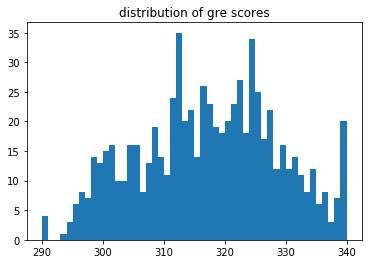

In [ ]:
plt.hist(train_set_copy['gre'], bins = 50)
plt.title('distribution of gre scores')
pass

The distribution is noisy but appears to be fairly normal in shape. Scores range from 290 to 340

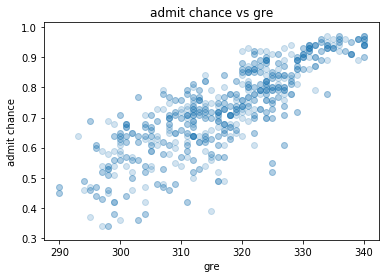

In [ ]:
plt.scatter(train_set_copy['gre'], train_set_copy['admit_chance'], alpha=0.2)
plt.xlabel('gre')
plt.ylabel('admit chance')
plt.title("admit chance vs gre")
pass

Gre appears to have a large positive correlation with admit_chance. This would be beneficial to look at further down the line.

**Test of English as a Foreign Language Scores**
-----------
- floating point value (looks like it could be an integer if the .0's are truncated off) with 256 values missing. This will probably not be as useful because a large number of the applicants did not take this test, but for the ones who did this may be another good indicator. 

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


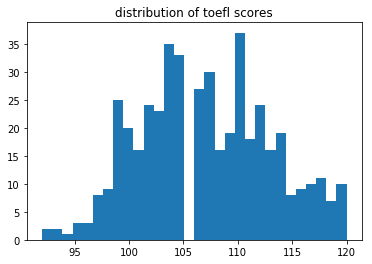

In [ ]:
plt.hist(train_set_copy['toefl'], bins = 30)
plt.title('distribution of toefl scores')
pass

The distribution here is similar to the gre data, this is fairly normal in shape with the exception of a hole in the middle at 105.

Considering that if someone did not take this test then the applicant is a native english speaker, it would make sense to fill the NaN values with close to a perfect score. We are not just removing the values with NaN's because there are not too many datapoints to begin with, so we cannot afford to drop that many.

In [ ]:
train_set_copy['toefl'] = train_set_copy['toefl'].fillna(100)

In [ ]:
train_set_copy.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 720 entries, 437 to 530
Data columns (total 8 columns):
gre             720 non-null int64
toefl           720 non-null float64
university      720 non-null int64
sop             720 non-null float64
lor             681 non-null float64
gpa             720 non-null float64
research        720 non-null object
admit_chance    720 non-null float64
dtypes: float64(5), int64(2), object(1)
memory usage: 50.6+ KB


All of the toefl values have been filled.

**University**
---------
- integer value with no missing values. This attribute will likely be useful because basically every graduate applicant in this dataset has a value for this. on a scale from 1 - 5. 

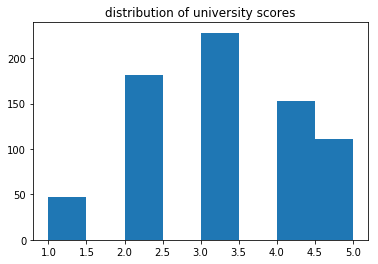

In [ ]:
plt.hist(train_set_copy['university'], bins = 8)
plt.title('distribution of university scores')
pass

**Statement of Purpose Quality** 
----------
- floating point value with no missing values. This attribute will likely be useful because every applicant in this dataset has a value for this attribute. This is also on a scale from 1 - 5.

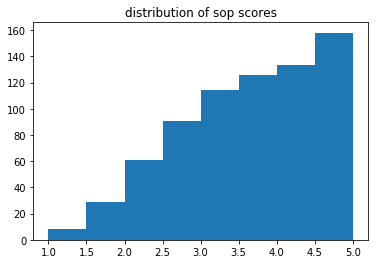

In [ ]:
plt.hist(train_set_copy['sop'], bins = 8)
plt.title('distribution of sop scores')
pass

This data appears to be left skewed, and most applicants have values close to 5. There are no holes. This may be a good candidate for a transformation if the correlation is not already high enough. We will also check the shape again in a scatter matrix.

**Letter of Reccomendation Quality** 
-------
- floating point value with 40 missing values. This is also on a scale from 1 - 5. Probably important because most applicants have this.

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


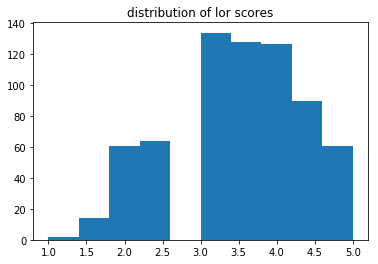

In [ ]:
plt.hist(train_set_copy['lor'], bins = 10)
plt.title('distribution of lor scores')
pass

This data appears to be heavily left skewed, and most applicants have values close to 5. This may be a good candidate for a transformation. It also needs the NaN values to be filled. There are no holes and if the correlation is already high we may not need a transformation.

assuming that if an applicant does not have a value for their lor or has a NaN that means they do not have a letter of rec so we can fill them with 0's. We are not just dropping the datapoints with NaN's because we do not have many samples to begin with so we can not afford to drop very many.

In [ ]:
train_set_copy['lor'] = train_set_copy['lor'].fillna(0)

In [ ]:
train_set_copy.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 720 entries, 437 to 530
Data columns (total 8 columns):
gre             720 non-null int64
toefl           720 non-null float64
university      720 non-null int64
sop             720 non-null float64
lor             720 non-null float64
gpa             720 non-null float64
research        720 non-null object
admit_chance    720 non-null float64
dtypes: float64(5), int64(2), object(1)
memory usage: 50.6+ KB


Now there are no more NaN values in the data to be dealt with and we can check the data more thoroughly

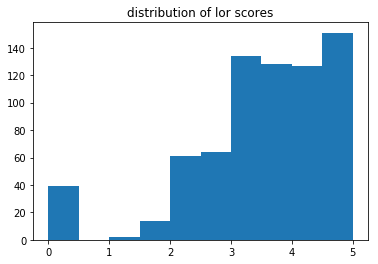

In [ ]:
plt.hist(train_set_copy['lor'], bins = 10)
plt.title('distribution of lor scores')
pass

Filling the NaN's did not change much, it just added more values at 0 as was expected.

**Grade Point Average on 4.0 scale** 
---------
- floating point value with no missing values. This attribute pretty much definitely be useful because every applicant in this dataset has a value for this attribute and from intuition/prior knowlege, grade point average is important. This is on a scale from 0 - 4, but in the data the min is 2.72 and the max is 3.97

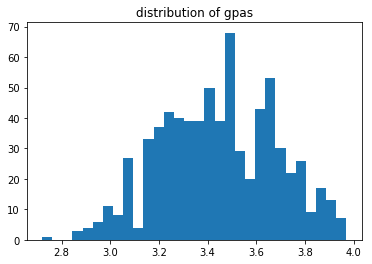

In [ ]:
plt.hist(train_set_copy['gpa'], bins = 30)
plt.title('distribution of gpas')
pass

Yet another attribute with a good bell shaped curve. This attribute has no holes and nothing missing to be filled in so it will possibly be one of the best predictors of admit_chance

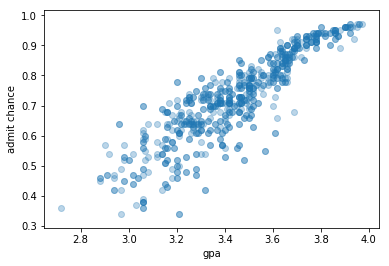

In [ ]:
plt.scatter(train_set_copy['gpa'], train_set_copy['admit_chance'], alpha=0.3)
plt.xlabel('gpa')
plt.ylabel('admit chance')
pass

GPA appears to have a really strong correlation with admit chance. Again, this seems like it would be very important in the final algorithm.

**Research** 
----------
- yes or no attribute with no missing values. This attribute in its current state would not be very useful, but could be changed into a boolean value or a one hot encoder attribute. 

In [ ]:
train_set_copy.research.value_counts() / len(train_set_copy) * 100 # displays as percentage

yes    55.416667
no     44.583333
Name: research, dtype: float64

44.4% of applicants in our sample have not done research while 55.6% have

In [ ]:
#Changing yeses and nos to 1's and 0's respectively
train_set_copy = train_set_copy.replace('yes', 1)
train_set_copy = train_set_copy.replace('no', 0)

In [ ]:
#Verifying that it worked correctly
train_set_copy[:10]

,gre,toefl,university,sop,lor,gpa,research,admit_chance
437,323,104.0,3,4.0,4.0,3.38,1,0.73
677,318,110.0,3,4.0,0.0,3.52,0,0.63
328,319,100.0,3,2.5,2.0,3.48,1,0.78
58,335,115.0,4,4.5,4.5,3.87,1,0.93
149,320,110.0,5,5.0,5.0,3.68,1,0.88
420,311,104.0,3,4.0,3.5,3.25,1,0.74
265,321,100.0,3,3.5,4.0,3.60,1,0.80
816,312,99.0,1,1.0,0.0,3.20,1,0.52
9,335,117.0,5,5.0,5.0,3.93,1,0.96
606,319,108.0,2,2.5,3.0,3.50,0,0.66


This makes research into a one hot encoded attribute for whether or not the applicant has done research.

**Chance of Admittance** 
--------------
- floating point value from 0 - 1 for the chance the applicant has at being admitted to grad school. This is the target attribute and as such will not be recieving any transformations or changes.

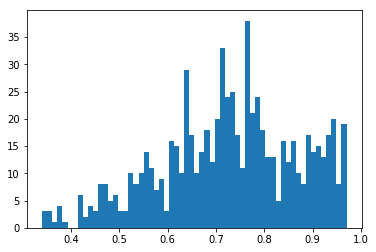

In [ ]:
plt.hist(train_set_copy['admit_chance'], bins = 60)
pass

Slightly skewed left shape but overall seems bellshaped with a lot of noise. This is the target attribute so we will not be transforming it at all but it is good to know it has an ideal expected shape

## 3. For supervised learning tasks, identify the target attribute(s)

The target attribute is admit_chance

In [ ]:
train_set_copy.describe()

,gre,toefl,university,sop,lor,gpa,research,admit_chance
count,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000
mean,316.884722,104.547222,3.138889,3.415972,3.295833,3.444069,0.554167,0.726597
std,11.409402,5.918594,1.150746,0.979744,1.185205,0.238068,0.497403,0.142364
min,290.000000,92.000000,1.000000,1.000000,0.000000,2.720000,0.000000,0.340000
25%,309.000000,100.000000,2.000000,2.500000,2.875000,3.270000,0.000000,0.640000
50%,317.000000,102.000000,3.000000,3.500000,3.500000,3.460000,1.000000,0.730000
75%,325.000000,109.000000,4.000000,4.000000,4.000000,3.630000,1.000000,0.840000
max,340.000000,120.000000,5.000000,5.000000,5.000000,3.970000,1.000000,0.970000


No attribute has heinous outliers, no attribute has any values missing anymore and they all look as we would expect them to.

## 4. Visualize the data

Looking at all the distributions and comparing them with each other

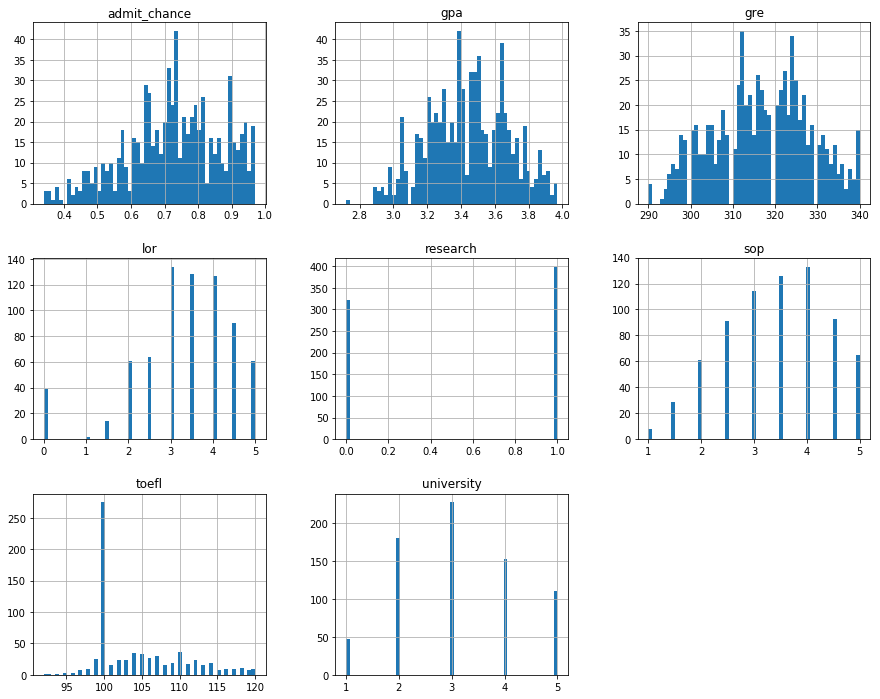

In [ ]:
train_set_copy.hist(bins=55, figsize=(15,12))
pass

Yet again, most distributions are bell shaped. When breaking lor and sop down again with a different number of bins they seem less skewed than before. A good next step is to look at all the scatter plots between attributes to see how they connect/correlate with each other.

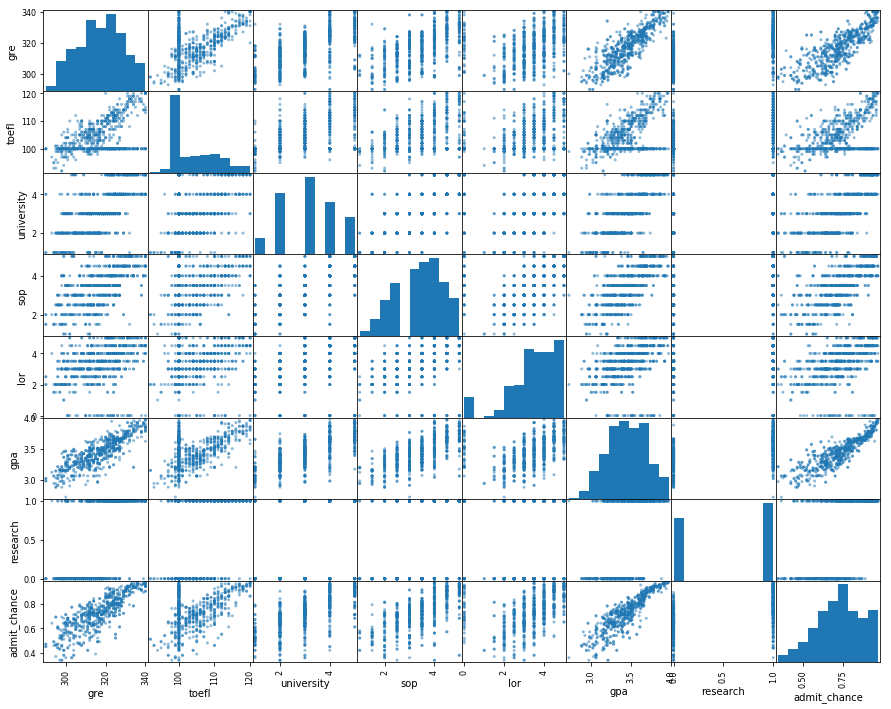

In [ ]:
scatter_matrix(train_set_copy, figsize=(15,12))
pass

The plots we care about the most are with each attribute and admit_chance. That being said, most have a positive slope/correlation. As stated above, gre and gpa both have strong correlations with admit_chance, while toefl has a slightly weaker but still positive correlation. sop lor and university form lines because each value is from 0 - 5 and only every 0.5. This makes them less usefull and makes the graphs look more peculiar. And of course research is categorical so it should not appear with a scatter plot.

Because all the graphs look linear and positive like this we do not need to apply transformations to fit them better.

## 5. Study the correlations between attributes

At this point we have discovered lots of things in indivdual attributes and setup our data for further study. Now we want to look for some correlations in it, especially with the target atribute admit_chance

In [ ]:
train_set_copy.corr()

,gre,toefl,university,sop,lor,gpa,research,admit_chance
gre,1.000000,0.507996,0.644019,0.593183,0.346053,0.832952,0.595042,0.819237
toefl,0.507996,1.000000,0.404389,0.383546,0.255659,0.505421,0.299836,0.469789
university,0.644019,0.404389,1.000000,0.724628,0.418527,0.715237,0.453374,0.697429
sop,0.593183,0.383546,0.724628,1.000000,0.462208,0.705539,0.439590,0.674809
lor,0.346053,0.255659,0.418527,0.462208,1.000000,0.438641,0.248810,0.449975
gpa,0.832952,0.505421,0.715237,0.705539,0.438641,1.000000,0.533778,0.880281
research,0.595042,0.299836,0.453374,0.439590,0.248810,0.533778,1.000000,0.566007
admit_chance,0.819237,0.469789,0.697429,0.674809,0.449975,0.880281,0.566007,1.000000


The correlation coefficients are all very high, especially 0.812519 from gre and 0.879971 from gpa. University and sop  are also very high, but all the other ones are a bit lower. This could be possibly because their scale is different, so in the preprocessing we will implement a standard scaler. 

The bottom line is every attribute has a very high correlation with admit_chance. Because of everything we found above, and the fact that the correlations are already very high, we believe there is no good reason to apply any transformations onto the data. 

## 6. Study how you would solve the problem manually

The attributes with the highest correlation seem to be gre, gpa and university. To solve manually, you should look at these attributes and if they are above a certain value determined for the school, then they will likely have a high admit_chance. We could also try and find an earlier applicant who had similar scores to them in these metrics and see if they were accepted or not. 

##  7. Identify the promising transformations you may want to apply

As stated above, beyond a standard scaler and an imputer to fill in the misisng values, there are no transformations we would like to apply.

## 8. Identify extra data that would be useful


There is no extra data that we could manufacture from this such as new attributes that would help. However, there are a few things that could help if we were involved in the collection of data.

The biggest thing thing that would help is getting more data. 900 values may seem like a large number of applicants, but in other models we have needed many many more than this. Another helpful attribute would possibly be some metric about the subject area the applicant is in because graduate school is more selective depending on the field of study. 










9.Document what you have learned

## Summary
-------


**Extremely Important features:**
* `gpa`
* `gre`

**Semi useful:**
* `University`
* `lor/log_lor`
*  `sop`
* `toefl`
* `research`

**Cleanup / Feature Extraction / Transforms:**
 * Fill in NaN values in attributes like `toefl` and `lor`
* Standardize the data with a standard scaler

Overall most attributes have very strong correlations to `admit_chance`. Hopefully the fact that there are such strong correlations will make up for the fact that there are not as many data values. 

Prepare the Data
=====

1.Data cleaning:Fix/remove outliers (optional); Fill in missing values (with 0, mean, median...) or drop rows/columns

2.Feature selection (optional):Drop attributes that provide no useful information for the task

3.Feature engineering, where appropriate:Discretize continuous features; Decompose features (categorical, date/time, ...), Add promising transformationsof features (log(x), √x, $x^2$, ...); Aggregate features into promising new features

4.Feature scaling:standardize or normalize features

In [ ]:
data, labels = split_labels(train_set, "admit_chance")
preprocessor = create_preprocessor()
data_prepped = preprocessor.fit_transform(data)

In [ ]:
pipeline = SupervisedPipeline(
    RemoveBadData(), 
    "admit_chance",        # column with label
    preprocessor,    # cleans data and extracts features
)

In [ ]:
pipeline.fit(train_set)
X,y = pipeline.transform_xy(train_set)

Short-List Promising Models
=======

1.Train many quick and dirty models from different categories (e.g. linear, naive Bayes, SVM, Random Forests, neural net, ...) using standard parameters

2.Measure and comparetheir performance. For each model, use n-fold cross-validation and compute the mean and standard deviation of the performance measure on the nfolds.

3.Analyze the most significant variables for each algorithm

4.Analyze the types of errors the models make.What data would a human have used to avoid these errors?

5.Have a quick round of feature selection and engineering

6.Have one or two more quick iterations of the five previous steps

7.Short-list the top three to five most promising models, preferring models that make different types of errors

In [ ]:
en_reg = ElasticNet()
en_reg.fit(data_prepped, labels)

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [ ]:
dt_reg = DecisionTreeRegressor()
dt_reg.fit(data_prepped, labels)
get_error(dt_reg, data_prepped, labels)

(2.9836347275412064e-17,
 array([0.07048443, 0.04469029, 0.05708181, 0.05155903, 0.07897784,
        0.05155903, 0.0702278 , 0.0505525 , 0.0666875 , 0.04826144]),
 0.05900816844721015,
 0.011054534054963145)

In [ ]:
rf_reg = RandomForestRegressor()
rf_reg.fit(data_prepped, labels)
get_error(rf_reg, data_prepped, labels)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


(0.02070275746529111,
 array([0.059535  , 0.03706732, 0.04661962, 0.05106858, 0.05942549,
        0.04709049, 0.06155418, 0.05232099, 0.05764728, 0.04364296]),
 0.05159719064976711,
 0.007617828164278409)

In [ ]:
et_reg = ExtraTreesRegressor()
et_reg.fit(data_prepped, labels)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
          oob_score=False, random_state=None, verbose=0, warm_start=False)

In [ ]:
sgd_reg = SGDRegressor(max_iter=10, tol=0.19)
sgd_reg.fit(data_prepped, labels)

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=10,
       n_iter=None, n_iter_no_change=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, tol=0.19, validation_fraction=0.1,
       verbose=0, warm_start=False)

In [ ]:
sgd_reg.get_params

<bound method BaseEstimator.get_params of SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=10,
       n_iter=None, n_iter_no_change=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, tol=0.19, validation_fraction=0.1,
       verbose=0, warm_start=False)>

Fine-Tune the System
========

1.Fine-tune the hyperparameters using cross-validation. Treat your data transformation choices as hyperparameters, especially when you are not sure about them. Unless there are very few hyperparameter values to explore, prefer random search over grid search. If training is very long, you may prefer a Bayesian optimization approach.

2.Try Ensemble methods. Combining your best models will often perform better than running them individually.

3.Once you are confident about your final model, measure its performance on the test set to estimate the generalization error.

In [ ]:
pipeline = SupervisedPipeline(RemoveBadData(), "admit_chance", preprocessor, dt_reg)

param_grid = {'estimator__max_depth': [5, 10, 15],
    'estimator__min_samples_leaf': [5, 10, 20]
}

dt_opt = GridSearchCV(pipeline, param_grid, cv=2)
dt_opt.fit(*pipeline.split_xy(train_set)) # magic here!

GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=SupervisedPipeline(estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
          ...      n_values=None, sparse=True))]), ['research'])]),
          train_preprocessor=RemoveBadData()),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'estimator__max_depth': [5, 10, 15], 'estimator__min_samples_leaf': [5, 10, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [ ]:
dt_opt.best_params_

{'estimator__max_depth': 5, 'estimator__min_samples_leaf': 5}

In [ ]:
pipeline = SupervisedPipeline(RemoveBadData(), "admit_chance", preprocessor, dt_reg)

param_grid = {'estimator__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
    'estimator__min_samples_leaf': [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]       
}

dt_opt = GridSearchCV(pipeline, param_grid, cv=2)
dt_opt.fit(*pipeline.split_xy(train_set)) # magic here!

GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=SupervisedPipeline(estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
          ...      n_values=None, sparse=True))]), ['research'])]),
          train_preprocessor=RemoveBadData()),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'estimator__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9], 'estimator__min_samples_leaf': [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [ ]:
pipeline = SupervisedPipeline(RemoveBadData(), "admit_chance", preprocessor, rf_reg)

param_grid = {'estimator__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'estimator__min_samples_leaf': [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]       
}

rf_opt = GridSearchCV(pipeline, param_grid, cv=2)
rf_opt.fit(*pipeline.split_xy(train_set)) # magic here!

GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=SupervisedPipeline(estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_...      n_values=None, sparse=True))]), ['research'])]),
          train_preprocessor=RemoveBadData()),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'estimator__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'estimator__min_samples_leaf': [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [ ]:
rf_opt.best_params_

{'estimator__max_depth': 10, 'estimator__min_samples_leaf': 7}

In [ ]:
dt_opt.best_params_

{'estimator__max_depth': 8, 'estimator__min_samples_leaf': 13}

In [ ]:
dt_reg_pg = DecisionTreeRegressor(max_depth=5, min_samples_leaf=5) # pg meaning post grid
dt_reg_pg.fit(data_prepped, labels)

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=5,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [ ]:
rf_reg = RandomForestRegressor(max_depth=4, min_samples_leaf=9)
rf_reg.fit(data_prepped, labels)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=9, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

# Scoring

We used Root Mean Squared Error for all of our models to determine our best model. Below are all the scores for each model.

SGD Regression
-----

In [ ]:
get_error(sgd_reg, data_prepped, labels)

(0.06120132444860641,
 array([0.07413416, 0.05855965, 0.06447222, 0.06187671, 0.06491677,
        0.04978153, 0.05677789, 0.06985844, 0.06827839, 0.04791303]),
 0.06165687976286527,
 0.008054243822354073)

Random Forest
------

In [ ]:
get_error(rf_reg, data_prepped, labels)

(0.05744875586802653,
 array([0.07506548, 0.05910978, 0.062563  , 0.05854526, 0.06808524,
        0.04731919, 0.059144  , 0.0636004 , 0.07001636, 0.05166814]),
 0.06151168481962701,
 0.00789437453235295)

Decision Tree
-------

In [ ]:
get_error(dt_reg_pg, data_prepped, labels)

(0.05496472456072892,
 array([0.0718837 , 0.05659094, 0.07022432, 0.05615711, 0.06446719,
        0.04774822, 0.06332771, 0.06396908, 0.07020669, 0.04802439]),
 0.06125993491599219,
 0.008371111016008759)

Extra Trees
-------

In [ ]:
get_error(et_reg, data_prepped, labels)

(1.0530468477399103e-16,
 array([0.05408712, 0.04068511, 0.03425051, 0.03710907, 0.05625068,
        0.05701352, 0.04918954, 0.04881854, 0.04977198, 0.03480022]),
 0.046197629516703045,
 0.008333741612245354)

Elastic Net
-------

In [ ]:
get_error(en_reg, data_prepped, labels)

(0.1422652217712301,
 array([0.15225668, 0.14076977, 0.12742942, 0.13693114, 0.1405414 ,
        0.13855618, 0.13648531, 0.1555877 , 0.15176584, 0.14244124]),
 0.1422764693319751,
 0.008176396369625246)

# Review of Scores

Based on our scoring results we noticed that our Extra Trees Model seems to be overfitting the training set. The other models don't seem to be over or underfitting on the training set. Our best overall model, based on average RMSE, is the Extra Trees model even though it is overfitting. To correct for this we plan to run a Grid Search in hopes of finding better parameters to use on the model for future.

Below is a few grid searches to find the best parameters for our extra trees model which will increase regularization and decrease overfitting.

In [ ]:
pipeline = SupervisedPipeline(RemoveBadData(), "admit_chance", preprocessor, et_reg)

param_grid = {'estimator__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'estimator__min_samples_leaf': [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]       
}

et_opt = GridSearchCV(pipeline, param_grid, cv=2)
et_opt.fit(*pipeline.split_xy(train_set)) # magic here!

GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=SupervisedPipeline(estimator=ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fract...      n_values=None, sparse=True))]), ['research'])]),
          train_preprocessor=RemoveBadData()),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'estimator__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'estimator__min_samples_leaf': [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [ ]:
et_opt.best_params_

{'estimator__max_depth': 6, 'estimator__min_samples_leaf': 8}

In [ ]:
pipeline = SupervisedPipeline(RemoveBadData(), "admit_chance", preprocessor, et_reg)

param_grid = {'estimator__max_depth': [8, 9, 10, 11, 12, 13, 14, 15],
    'estimator__min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 10]       
}

et_opt = GridSearchCV(pipeline, param_grid, cv=2)
et_opt.fit(*pipeline.split_xy(train_set)) # magic here!

GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=SupervisedPipeline(estimator=ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fract...      n_values=None, sparse=True))]), ['research'])]),
          train_preprocessor=RemoveBadData()),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'estimator__max_depth': [8, 9, 10, 11, 12, 13, 14, 15], 'estimator__min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [ ]:
et_opt.best_params_

{'estimator__max_depth': 12, 'estimator__min_samples_leaf': 2}

In [ ]:
pipeline = SupervisedPipeline(RemoveBadData(), "admit_chance", preprocessor, et_reg)

param_grid = {'estimator__max_depth': [8, 9, 10, 11, 12, 13, 14, 15],
    'estimator__min_samples_leaf': [1, 2, 3, 4, 5, 6]       
}

et_opt = GridSearchCV(pipeline, param_grid, cv=2)
et_opt.fit(*pipeline.split_xy(train_set)) # magic here!

GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=SupervisedPipeline(estimator=ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fract...      n_values=None, sparse=True))]), ['research'])]),
          train_preprocessor=RemoveBadData()),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'estimator__max_depth': [8, 9, 10, 11, 12, 13, 14, 15], 'estimator__min_samples_leaf': [1, 2, 3, 4, 5, 6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [ ]:
et_opt.best_params_

{'estimator__max_depth': 14, 'estimator__min_samples_leaf': 1}

In [ ]:
et_reg_pg = ExtraTreesRegressor(max_depth=11, min_samples_leaf=2)
et_reg_pg.fit(data_prepped, labels)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=11,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=2, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
          oob_score=False, random_state=None, verbose=0, warm_start=False)

In [ ]:
get_error(et_reg_pg, data_prepped, labels)

(0.021032916631339046,
 array([0.06120638, 0.04568923, 0.04572392, 0.04433356, 0.0580488 ,
        0.05188652, 0.05940007, 0.05282628, 0.05505775, 0.04233869]),
 0.05165112092963411,
 0.00645186141059821)

With a 0.02 rmse on the training set and an average of 0.04 on the cross val scores, this model is no longer overfitting as much as before. This is our final model.

Extra trees is an ensemble regressor and because of this tends to be more accurate than single regressors and does not overfit as much. With our final model, we can now test on our testing data.

In [ ]:
data, labels = split_labels(test_set, "admit_chance")
preprocessor = create_preprocessor()
data_prepped = preprocessor.fit_transform(data)


pipeline.fit(test_set)
X,y = pipeline.transform_xy(test_set)

X_test, y_test = pipeline.split_xy(test_set)
y_pred = et_reg_pg.predict(data_prepped)
training_error, cross_val_scores, mean_cross_val_score, std_dev_score = get_error(et_reg_pg, data_prepped, labels)

0.0728206986272174

Present Your Solution
======

1.Document what you have done

2.Create a nice presentation, highlightingthe big picture first

3.Explain why your solution achieves the business objective

4.Don’t forget to present interesting points you noticed along the way: Describe what worked and what did not; List your assumptions and your system’s limitations

5.Ensure your key findings are communicated through beautiful visualizations or easy-to-remember statements (e.g. “the median income is the number-one predictor of housing prices”)

# Documentation

After examining the data and the correlations between each column, we realized that there are already very good correlations between GPA, GRE, and Admittance Chance. Once we documented that, we decided against transforming the data in any way. For preprocessing we used a standard scaler to make the data on the same scale and an imputer to fill in the missing values in attributes such as toefl and research.

When it came to training, we found that the Extra Trees Regressor was the best in terms of creating great results. The overall score of that test had a root mean squared error value of around .04 and this is great for our client since this low error will allow them to make more money using our technology.


# Presentation

In [ ]:
print("Mean Root Mean Squared Error :",mean_cross_val_score)

Mean Root Mean Squared Error : 0.0646932186817003


The above scores show the accuracy in the final product using the Extra Trees Regressor model. Below are the ten scores from our cross validation testing.

In [ ]:
print("Cross Validation Scores : ")
for i in range(len(cross_val_scores)):
  print("Score {0}  :  {1}".format(i+1, np.round((cross_val_scores[i]), 3)))

Cross Validation Scores : 
Score 1  :  0.083
Score 2  :  0.074
Score 3  :  0.082
Score 4  :  0.071
Score 5  :  0.055
Score 6  :  0.049
Score 7  :  0.06
Score 8  :  0.08
Score 9  :  0.053
Score 10  :  0.04


# Interesting Facts

Without Feature Transformation and Extraction, the dataset was very well correlated. We found this to be very interesting and suspicious at the same time. The only preprocessing we needed was a standard scaler and an imputer for the missing values.

In terms of what worked and what did not work, we realized that Extra Trees worked the best even with slight overfitting. All of the other models, worked pretty well but not quite as well as Extra Trees. Elastic Net, for example, had the highest root mean squared error of 0.14. Compared to Extra Trees, we had an initial value of 0.04, which is a pretty decent difference.

We assumed that Extra Trees or Random Forest would have worked best because they are Ensemble Regressors. Ensemble regressors are more likely going to perform better than other models and are less prone to overfitting. Rather than creating our own ensemble with a strategy such as bagging or pasting, we stuck with Extra Trees and Random Forest as two of our best options.

There were no apparent limitations in our system.


# Data Presentation

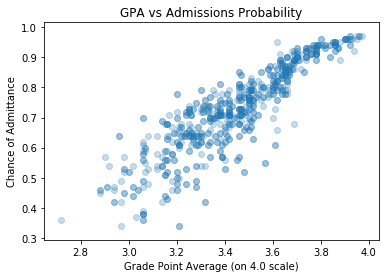

In [ ]:
plt.scatter(train_set_copy['gpa'], train_set_copy['admit_chance'], alpha=0.25)
plt.xlabel('Grade Point Average (on 4.0 scale)')
plt.ylabel('Chance of Admittance')
plt.title("GPA vs Admissions Probability")
pass

**The higher GPA a student has, the more likely they are to be accepted into a college, university, or graduate school.**

Client Oriented Presentation
-------
Our solution achieves the business objectives because it can accurately predict an applicant's chances of being admitted to graduate school based on the given attributes. This system is more accurate and consistent than the current method of a staff member making an educated guess on if an applicant would be accepted. One interesting thing we found was that GPA was the greatest predictor or admittance chance. (the graph above shows this strong correlation).

With our solution the company can consistently predict where students can go and almost guarantee where they will get in. With this the "acceptance or your money back" policy can stay longer and the company will lose much less money. 
